<a href="https://colab.research.google.com/github/Alina-Telnova/Machine-learning_Telnova/blob/main/%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Домашнее задание 2 будет более свободным по форме:

- собрать небольшой корпус текстов в формате *.txt
- обучить и протестировать векторную модель любым способом Word2Vec (CBOW, Skip-gram), GloVe, FastText
- можно использовать gensim, можно обучать W2V с нуля (если вы достаточно опытные) и т.д.

Главное, чтобы "на выходе" у вас была своя обученная модель, несколько примеров семантически близких слов и 1 визуалка

In [6]:
!pip install pymorphy3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 56.2 MB/s eta 0:00:00


In [5]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 13.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


In [2]:
!pip install --upgrade numpy
!pip install --no-cache-dir --force-reinstall gensim

  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [19]:
# загружаем все, что нам может понадобиться
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from pymorphy3 import MorphAnalyzer
from sklearn.manifold import TSNE
from pprint import pprint as print
from gensim.models.fasttext import FastText

# Загружаем стоп-слова из NLTK
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')

stop_words = set(stopwords.words('russian'))
morph = MorphAnalyzer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [10]:
with open('Акт_второй_Пастернак.txt') as text1, open('Акт_первый_Пастернак.txt') as text2, open('Акт_пятый_Пастернак.txt') as text3, open('Акт_третий_Пастернак.txt') as text4, open('Акт_четвертый_Пастернак.txt') as text5 :
    pasternak_texts = text1.read() + text2.read() + text3.read() + text4.read() + text5.read()
    print(pasternak_texts[:100])

('\n'
 'АКТ ВТОРОЙ \n'
 '\n'
 '\n'
 '\n'
 'СЦЕНА ПЕРВАЯ \n'
 '\n'
 'Эльсинор. Комната в доме Полония.\n'
 '\n'
 '\n'
 'Входят Полоний и Рейнальдо.\n'
 '\n'
 '\n'
 'Пол')


In [21]:
#Предобработка данных
def normalize_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'[^\w\s]', '', sentence)
    return sentence

def lemmatize_word(word):
    return morph.parse(word)[0].normal_form

def preprocess_text(text):
    sentences = sent_tokenize(text)
    tokenized_corpus = []
    for sentence in sentences:
        normalized_sentence = normalize_sentence(sentence)
        tokens = word_tokenize(normalized_sentence)
        tokens = [token for token in tokens if token not in stop_words]
        tokens = [lemmatize_word(token) for token in tokens]

        tokenized_corpus.append(tokens)

    return tokenized_corpus

pasternak_corpus = preprocess_text(pasternak_texts)
print(pasternak_corpus[:100])

[['акт', 'второй', 'сцена', 'первый', 'эльсинора'],
 ['комната', 'дом', 'полоний'],
 ['входить', 'полоний', 'рейнальдо'],
 ['полоний', 'деньга', 'письмо', 'он', 'рейнальдо'],
 ['рейнальдо', 'вручить', 'милорд'],
 ['полоний', 'б', 'ваш', 'свидание', 'голубчик', 'разнюхать', 'вести'],
 ['рейнальдо', 'это', 'хотеть', 'милорд'],
 ['полоний', 'похвально'],
 ['весьма', 'похвально'],
 ['видеть',
  'дружок',
  'сперва',
  'спросить',
  'датчанин',
  'париж',
  'средство',
  'ль',
  'род',
  'стоять',
  'дружба',
  'кто',
  'б',
  'открыться',
  'сын',
  'знать',
  'обиняк',
  'переходить',
  'прямо',
  'наступление',
  'подавать',
  'вид'],
 ['например',
  'сказать',
  'тон',
  'дальний',
  'знакомство',
  'знать',
  'друг',
  'встречать',
  'отец',
  'знак',
  'отчасти',
  'сам'],
 ['понятно'],
 ['рейнальдо', 'вполне', 'милорд'],
 ['полоний', 'отчасти', 'сам'],
 ['хотя', 'спешить', 'вставить', 'очень', 'мало'],
 ['это', 'шалопай'],
 ['врать', 'мёртвый', 'угодный', 'кроме', 'сумасбродство', 'в

In [55]:
# Проверяем, что corpus не пустой
if len(pasternak_corpus) == 0:
    raise ValueError("Корпус пуст!")

model_tokenized = FastText(vector_size=100)

model_tokenized.build_vocab(corpus_iterable=pasternak_corpus)

total_examples = len(pasternak_corpus)
total_words = sum(len(sentence) for sentence in pasternak_corpus)

model_tokenized.train(
    corpus_iterable=pasternak_corpus, epochs=10,  # Убедитесь, что epochs корректное значение
    total_examples=total_examples, total_words=total_words, compute_loss=True
)

print(model_tokenized)

In [44]:
similar_words = model_tokenized.wv.most_similar('судьба', topn=5)

# Выводим результат
print("Семантически близкие слова:")
for word, similarity in similar_words:
    print(f"{word}: {similarity}")

'Семантически близкие слова:'
'просить: 0.9999703764915466'
'показывать: 0.9999698996543884'
'видать: 0.9999697208404541'
'простить: 0.9999696016311646'
'попросить: 0.9999688863754272'


Звучит очень даже неплохо.

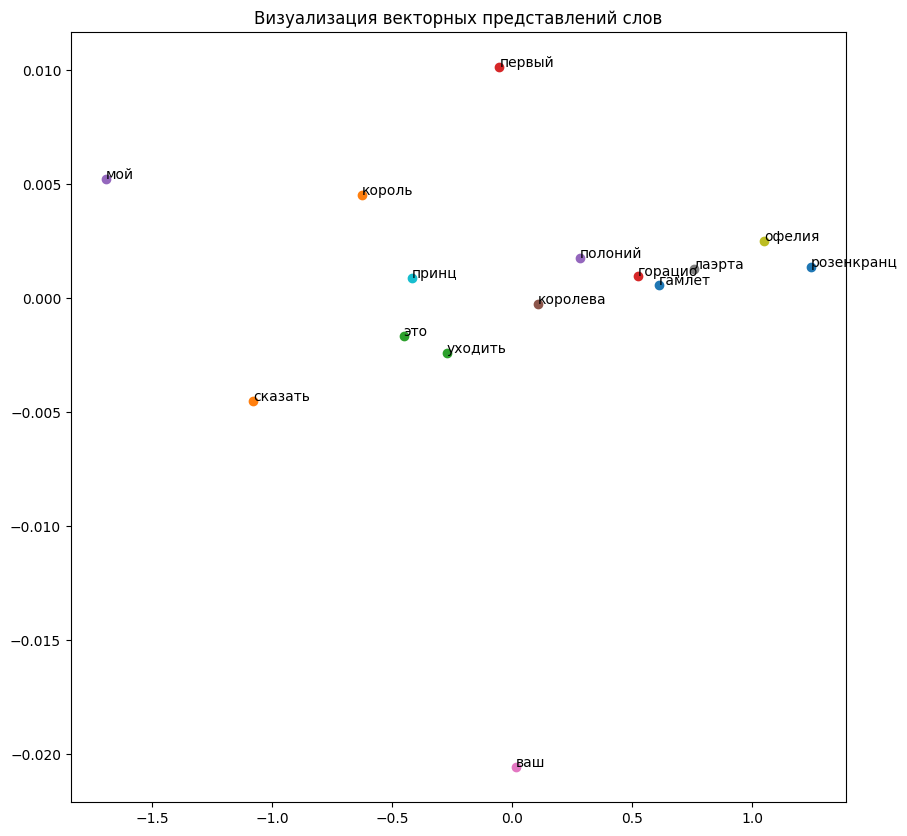

In [54]:
# Используем 15 наиболее частотных слов
top_words = model_tokenized.wv.index_to_key[:15]

word_vectors = model_tokenized.wv[top_words]

pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(word_vectors)
plt.figure(figsize=(10, 10))
for i, word in enumerate(top_words):
    plt.scatter(reduced_vectors[i, 0], reduced_vectors[i, 1])
    plt.text(reduced_vectors[i, 0], reduced_vectors[i, 1], word, fontsize=10)

plt.title("Визуализация векторных представлений слов")
plt.show()

# видим, что герои "притянулись друг другу" (что и логично), местоимения находятся на самом дальнем расстоянии.